In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams
from sklearn import model_selection
from tensorflow.python.framework import ops

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data = pd.read_csv('parkinsons.csv', delimiter=',')
data.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [3]:
# Store the features as X and the labels as y
X = data.drop(columns=['name', 'status'])
y = data['status']
X.shape

# 2. four best features as per mid sems
# X = data[['HNR','RPDE','DFA','PPE']]
# X.shape

# # 3. Two-factor components analysis as in file:///home/punny/Downloads/parkinson--published-IJSS%20(1).pdf
# X = data[['MDVP:PPQ', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ','Shimmer:DDA']].to_numpy()
# X.shape

# # 4. 2nd best Two-factor components analysis
# X = data[['MDVP:Jitter(%)','MDVP:Jitter(Abs)', 'MDVP:RAP', 'PPE', 'Jitter:DDP','NHR']].to_numpy()
# X.shape

# 5. 11 features for CC = 0.8
X = data[['MDVP:Fo(Hz)','MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Jitter(%)', 'HNR', 'RPDE', 'DFA', 'MDVP:Shimmer','spread1', 'spread2', 'D2']].values
X.shape

(195, 11)

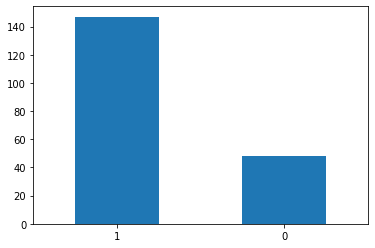

In [12]:
data.status.value_counts().plot(kind="bar", rot=0);

In [13]:
# CORRELATION
# corr_mat = data.corr() 
# fig, ax = plt.subplots(figsize=(20, 12)) 
# sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);
print(y.shape)

(65, 2)


<Figure size 720x432 with 0 Axes>

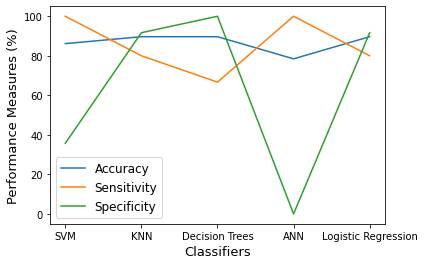

<Figure size 720x432 with 0 Axes>

In [26]:
x1 = [1,2,3,4,5]
acc = [86.15, 89.65, 89.65, 78.46, 89.65]
sens = [100,80,66.67,100,80]
spec = [35.71,91.67,100,0,91.67]
plt.plot(x1,acc,label="Accuracy")
plt.plot(x1,sens,label = "Sensitivity")
plt.plot(x1,spec,label = "Specificity")

plt.xlabel('Classifiers', fontsize=13)
plt.ylabel('Performance Measures (%)', fontsize=13)
plt.legend(fontsize=12)
my_xticks = ['SVM','KNN','Decision Trees','ANN','Logistic Regression']
plt.xticks(x1, my_xticks)
plt.figure(figsize=(10,6))

In [6]:
# 67% training set and 33% testing set
x_train, x_test, y_train, y_test = model_selection.train_test_split (X, y, test_size=0.33, random_state=0)
y_train = pd.get_dummies(y_train)
print(y_train.shape)

y_test = pd.get_dummies(y_test)

(130, 2)


In [7]:
n_input_features = x_train.shape[1]
n_input_features
print(n_input_features)
n_train_samples = x_train.shape[0]
print(n_train_samples)

11
130


In [8]:
# Create and train a tensorflow model of a neural network
def create_train_model(hidden_nodes, num_iters):
    
    # Reset the graph
    ops.reset_default_graph()

    # Placeholders for input and output data
    X = tf.placeholder(shape=(n_train_samples, n_input_features), dtype=tf.float64, name='x_train')
    y = tf.placeholder(shape=(n_train_samples, 2), dtype=tf.float64, name='y_train')

    # Variables for two group of weights between the three layers of the network
    W1 = tf.Variable(np.random.rand(n_input_features, hidden_nodes), dtype=tf.float64)
    W2 = tf.Variable(np.random.rand(hidden_nodes, 2), dtype=tf.float64)

    # Create the neural net graph
    # A1 = tf.sigmoid(tf.matmul(X, W1))
    A1 = tf.math.tanh(tf.matmul(X, W1))
    y_est = tf.math.tanh(tf.matmul(A1, W2))

    # Define a loss function
    deltas = tf.square(y_est - y)
    loss = tf.reduce_sum(deltas)

    # Define a train operation to minimize the loss
    optimizer = tf.train.AdamOptimizer(0.001)
    train = optimizer.minimize(loss)

    # Initialize variables and run session
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    # Go through num_iters iterations
    for i in range(num_iters):
        sess.run(train, feed_dict={X: x_train, y: y_train})
        loss_plot[hidden_nodes].append(sess.run(loss, feed_dict={X: x_train, y: y_train}))
        weights1 = sess.run(W1)
        weights2 = sess.run(W2)
        
    print("loss (hidden nodes: %d, iterations: %d): %.2f" % (hidden_nodes, num_iters, loss_plot[hidden_nodes][-1]))
    sess.close()
    return weights1, weights2

loss (hidden nodes: 1, iterations: 2000): 50.22
loss (hidden nodes: 2, iterations: 2000): 50.22
loss (hidden nodes: 3, iterations: 2000): 50.22
loss (hidden nodes: 4, iterations: 2000): 50.22


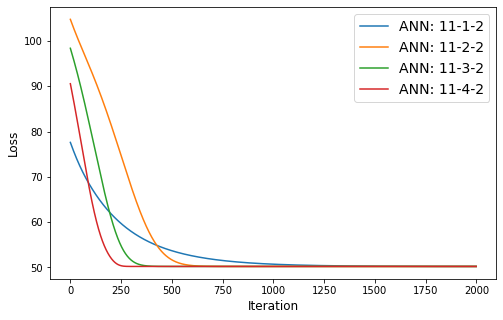

In [9]:
# Run the training for 3 different network architectures: (4-5-3) (4-10-3) (4-20-3)

# Plot the loss function over iterations
num_hidden_nodes = [1, 2, 3, 4]
loss_plot = {1: [], 2: [], 3: [], 4: []}
weights1 = {1: None, 2: None, 3: None, 4: None}
weights2 = {1: None, 2: None, 3: None, 4: None}
num_iters = 2000

plt.figure(figsize=(8,5))
for hidden_nodes in num_hidden_nodes:
    weights1[hidden_nodes], weights2[hidden_nodes] = create_train_model(hidden_nodes, num_iters)
    plt.plot(range(num_iters), loss_plot[hidden_nodes], label="ANN: 11-%d-2" % hidden_nodes)
    
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=14)

In [10]:
from sklearn.metrics import confusion_matrix

In [11]:
n_test_samples = x_test.shape[0]
# Evaluate models on the test set
X = tf.placeholder(shape=(n_test_samples, n_input_features), dtype=tf.float64, name='x_test')
y = tf.placeholder(shape=(n_test_samples, 2), dtype=tf.float64, name='y_test')

for hidden_nodes in num_hidden_nodes:
    # Forward propagation
    W1 = tf.Variable(weights1[hidden_nodes])
    W2 = tf.Variable(weights2[hidden_nodes])
    A1 = tf.math.tanh(tf.matmul(X, W1))
    y_est = tf.math.tanh(tf.matmul(A1, W2))

    # Calculate the predicted outputs
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        y_est_np = sess.run(y_est, feed_dict={X: x_test, y: y_test})

    # Calculate the prediction accuracy
    correct = [estimate.argmax(axis=0) == target.argmax(axis=0) 
               for estimate, target in zip(y_est_np, y_test.values)]
    accuracy2 = 100 * sum(correct) / len(correct)
    tp, tn, fp, fn = 0,0,0,0
    for i in range(n_test_samples):
        if(y_est_np[i].argmax(axis=0) == 1 and y_test.values[i][1] == 1):
            tp = tp + 1
        if(y_est_np[i].argmax(axis=0) == 0 and y_test.values[i][0] == 1):
            tn = tn + 1
        if(y_est_np[i].argmax(axis=0) == 1 and y_test.values[i][0] == 1):
            fp = fp + 1
        if(y_est_np[i].argmax(axis=0) == 0 and y_test.values[i][1] == 1):
            fn = fn + 1
    specificity = tn / (tn+fp)
    print("Specificity is : " , specificity)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print("Accuracy is : " , accuracy)
    sensitivity = tp / (tp + fn)
    print("Sensitivity is : " , sensitivity)
    print('Network architecture 4-%d-2, accuracy: ', (hidden_nodes, accuracy2))
    print("\n")

Specificity is :  0.0
Accuracy is :  0.7846153846153846
Sensitivity is :  1.0
Network architecture 4-%d-2, accuracy:  (1, 78.46153846153847)


Specificity is :  0.0
Accuracy is :  0.7846153846153846
Sensitivity is :  1.0
Network architecture 4-%d-2, accuracy:  (2, 78.46153846153847)


Specificity is :  0.0
Accuracy is :  0.7846153846153846
Sensitivity is :  1.0
Network architecture 4-%d-2, accuracy:  (3, 78.46153846153847)


Specificity is :  0.0
Accuracy is :  0.7846153846153846
Sensitivity is :  1.0
Network architecture 4-%d-2, accuracy:  (4, 78.46153846153847)


